### Why is inh only used for MSE comparison and not exc signals or both ?
### Why deactivated intNOISE !
### Why PFCdl, M1 and A1 ?

# Import libraries

In [1]:
%%capture --no-display
import os, random 
import numpy as np
from custom_simulation import CustomSimulation
from surface_preparer import SurfacePreparer
from connectome_editor import ConnectomeEditor
from utility import are_signals_similar

# Init data saving folder:
SAVE_FOLDER = './result/res'
ROOT_FOLDER = os.getcwd()
try:
    os.listdir(SAVE_FOLDER)
except:
    os.mkdir(SAVE_FOLDER)

# Introduction

This study employs The Virtual Brain (TVB) platform to execute a sequence of simulations as follows:

1) An auditory stimulus, S1, is presented to the Macaque.
2) Subsequently, a second auditory stimulus, S2, is presented.
3) The Macaque then determines whether S1 is similar to S2.
4) If a similarity is detected, the Macaque initiates a response by pressing a button.

The neural regions of interest in this investigation are the primary auditory cortex (A1), dorsolateral prefrontal cortex (PFCdl), and primary motor cortex (M1).
<br>
<br>
<br>
In the context of TVB's simulation capabilities, this pipeline can be distilled into the following series of steps:
1) Two separate simulations are performed within the A1 region, effectively mimicking the auditory inputs of S1 and S2. They are then analyzed within the 'decision-making' region of the brain, specifically the PFCdl, using the brain connectivity matrix for the Macaque.
2) A protocol is developed to compare the output responses from the PFCdl region corresponding to auditory stimuli S1 and S2.
3) Finally, a third simulation is run within the M1 region, which is conditioned on the results derived from the comparison of S1 and S2 in the PFCdl.
<br>
<br>

In order to streamline our experimental paradigm, we elected to focus solely on the neural activity within the right hemisphere. This strategic choice allowed us to maintain a manageable complexity in our study while still capturing significant neuronal dynamics. Additionally, to simulate the awakened state of the Macaque brain, we deliberately set the frequency adaptation parameter to a low value, specifically 5.

This approach effectively mirrors the behavioral sequence observed in the Macaque and could provide a clearer understanding of the neurobiological processes underpinning these responses.


# 1) Simulating Auditory Inputs in the Primary Auditory Cortex (A1) 

As an initial step, we substantially extended the inter-stimulus time window to an extremely high value of 1e9. This adjustment ensures that our simulation only incorporates a single auditory stimulus at a given time, thus effectively isolating the neuronal responses attributable to individual stimuli.

Additionally, a crucial task was to identify a dependable parameter within The Virtual Brain (TVB) framework that, upon modulation, could yield two distinct and distinguishable firing rate outputs in the primary auditory cortex (A1). After a series of intricate neural simulations, we selected 'stimulus values'referred to as 'stimvals'— as our variable of interest. 
In fact, our findings reveal a pronounced change in the neuronal firing rate in PFCdl between the stimulus values of 0.405 and 0.41.

### Initialise the simulation

In [2]:
# Define variable of interest
stimvals = [0.001, 0.405, 0.41, 2] # Stimulus strengths

# Define stimulus region
stim_region = {'A1_R': 'Primary auditory cortex'} 

# Load the surface/connectome to change
surface = SurfacePreparer(SAVE_FOLDER)

# Create and init a simulator object
customSim = CustomSimulation(SAVE_FOLDER, surface, stim_region, stimvals, isIntNoise = False)

# Find target region
target_region = 'PFCdl_R'
target_region_id = surface.id_finder(target_region)

### Run the simulation and output 4 plots (with different 4 stimvals )

... loading file: b5_stim0.001_A1_R
... loading file: b5_stim0.405_A1_R
... loading file: b5_stim0.41_A1_R
... loading file: b5_stim2_A1_R


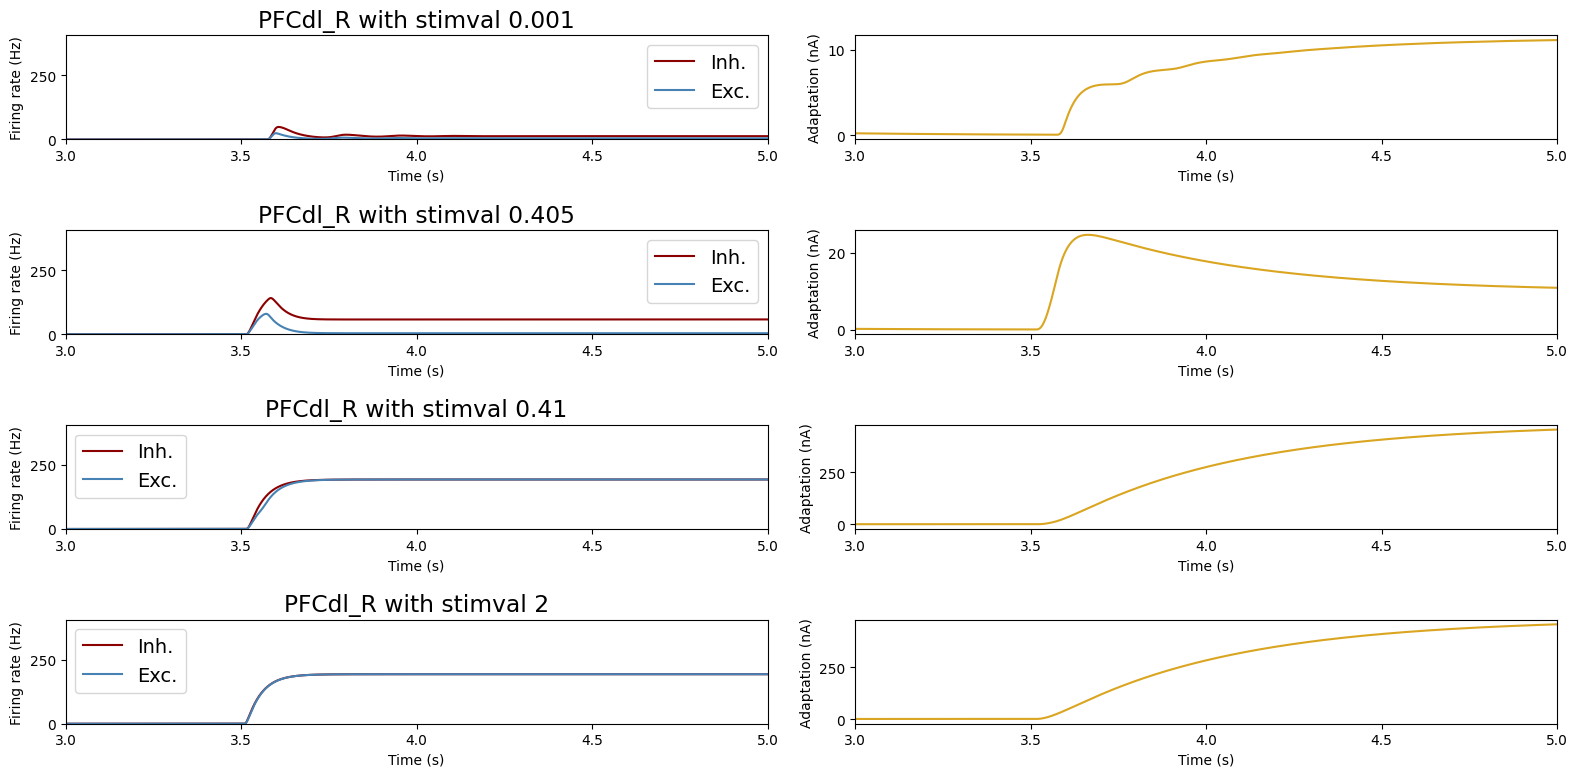

In [3]:
# Run the simulation
#customSim.main_simulation_loop() 

# Load simulation saved results
customSim.load_simulation() 

# PFCdl_R plot from A1
customSim.plot_simulation(target_region) 

# 2) Comparative Analysis of PFCdl Outputs Corresponding to Auditory Stimuli S1 and S2

This nuanced alteration in neuronal response potentially allows for the categorization of input signals in A1 into two groups: those associated with stimulus values less than or equal to 0.405 and those with stimulus values greater than or equal to 0.41. <br>
These findings present the possibility of developing a thresholding mechanism for signal categorization based on varying stimvals. Therefore, by analyzing the outputted neuronal firing rate in the prefrontal cortex, it may be possible to retroactively determine the initial stimulus value that was utilized in A1.
<br>
<br>
For the purpose of comparing the inhibitory firing rates resulting from two distinct simulations (i.e., simulations with varying stimulus values), we elected to use the Mean Square Error (MSE) algorithm. This algorithm is particularly suited to our study as it quantitatively measures the difference between two continuous variables, thereby enabling us to accurately evaluate the relative impact of differing stimulus values on inhibitory firing rates.

### Compute MSE (Mean Square Error) of each 4 simulations to define a threshold

In [4]:
signals_dict = customSim.get_signals(target_region_id)

signal0 = signals_dict[stimvals[0]] # with stimval = 0.001
signal1 = signals_dict[stimvals[1]] # with stimval = 0.405
signal2 = signals_dict[stimvals[2]] # with stimval = 0.41
signal3 = signals_dict[stimvals[3]] # with stimval = 2

are_signals_similar(signal0, signal1)
are_signals_similar(signal2, signal3)
are_signals_similar(signal1, signal2)
are_signals_similar(signal0, signal3)

MSE: 34.574663777510715
MSE: 2.733403337791166
MSE: 91.21913761853249
MSE: 123.35349977942418


Our analyses led us to identify a Mean Square Error (MSE) value of 60 as an optimal threshold for distinguishing between inhibitory firing rates in the dorsolateral prefrontal cortex (PFCdl) that originate from different stimulus values. This threshold provides a reliable demarcation point, facilitating a clear differentiation of neuronal responses based on their corresponding stimulus inputs.

# 3) Neural Response Evaluation: Running Conditioned Simulations within the Primary Motor Cortex (M1)

In this phase of the study, we incorporated a specialized 'press_button' function to simulate the action of the macaque pressing a button. In practical terms, this function initiates a new simulation within a specified target region—our choice being the primary motor cortex (M1)—with a selectable stimulus value.

Subsequently, we designed a 'task_decision' function, which randomly selects two inhibitory firing outputs from the four signals with different stimvalues we have previously simulated in (PFCdl). This function simulates the randomness inherent in the presentation of stimuli S1 and S2. Utilizing the Mean Square Error (MSE)-based threshold, we are then able to differentiate between the outputs corresponding to S1 and S2.

This information is then employed to modulate the stimulus input value in M1, effectively creating two distinct responses in this region—either a simulation of button pressing or a simulation without such an action.

In [16]:
def press_button(stim_region, stimval, is_plot = True):
    # Create and initialize the simulator with M1 as stimulus region
    customSim_button = CustomSimulation(SAVE_FOLDER, surface, stim_region, stimval,
                                   isIntNoise=False, isWeightNoise=True)
    
    # Run the simulation
    customSim_button.main_simulation_loop()

    if is_plot:
        # Load simulation variables
        customSim_button.load_simulation()
        # M1 plots
        target_region = list(motor_stim_region.keys())[0]
        customSim_button.plot_simulation(target_region)


def take_decision(time_series_dict, motor_stim_region, thresh=None, is_plot=False):
    # Select two random stimvals from signals_dict
    stimvals = random.sample(list(time_series_dict.keys()), 2)
    # Get the time series associated with the selected stimvals
    series1, series2 = time_series_dict[stimvals[0]], time_series_dict[stimvals[1]]
    
    print(f"Signals with stimval = {stimvals[0]} and {stimvals[1]} have been randomly selected")
    print(are_signals_similar(series1, series2))
    # Determine stimval in M1 based on time series similarity
    stimvalM1 = [0.001] if are_signals_similar(series1, series2, thresh) else [0.02]

    press_button(motor_stim_region, stimvalM1)      

Signals with stimval = 0.001 and 0.405 have been randomly selected
MSE: 34.574663777510715
None
Stim for 50 ms, 0.001 nS, b_val = 5, interstim [1000000000.0] mS in the M1_R
simulation time :1000.0


/home/turan/Downloads/TVB_Linux_2.7.2/TVB_Distribution/tvb_data/lib/python3.10/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


simulation time :2000.0
simulation time :3000.0
simulation time :4000.0
simulation time :5000.0
Simulation took 78.00 seconds to complete.
... loading file: b5_stim0.001_M1_R


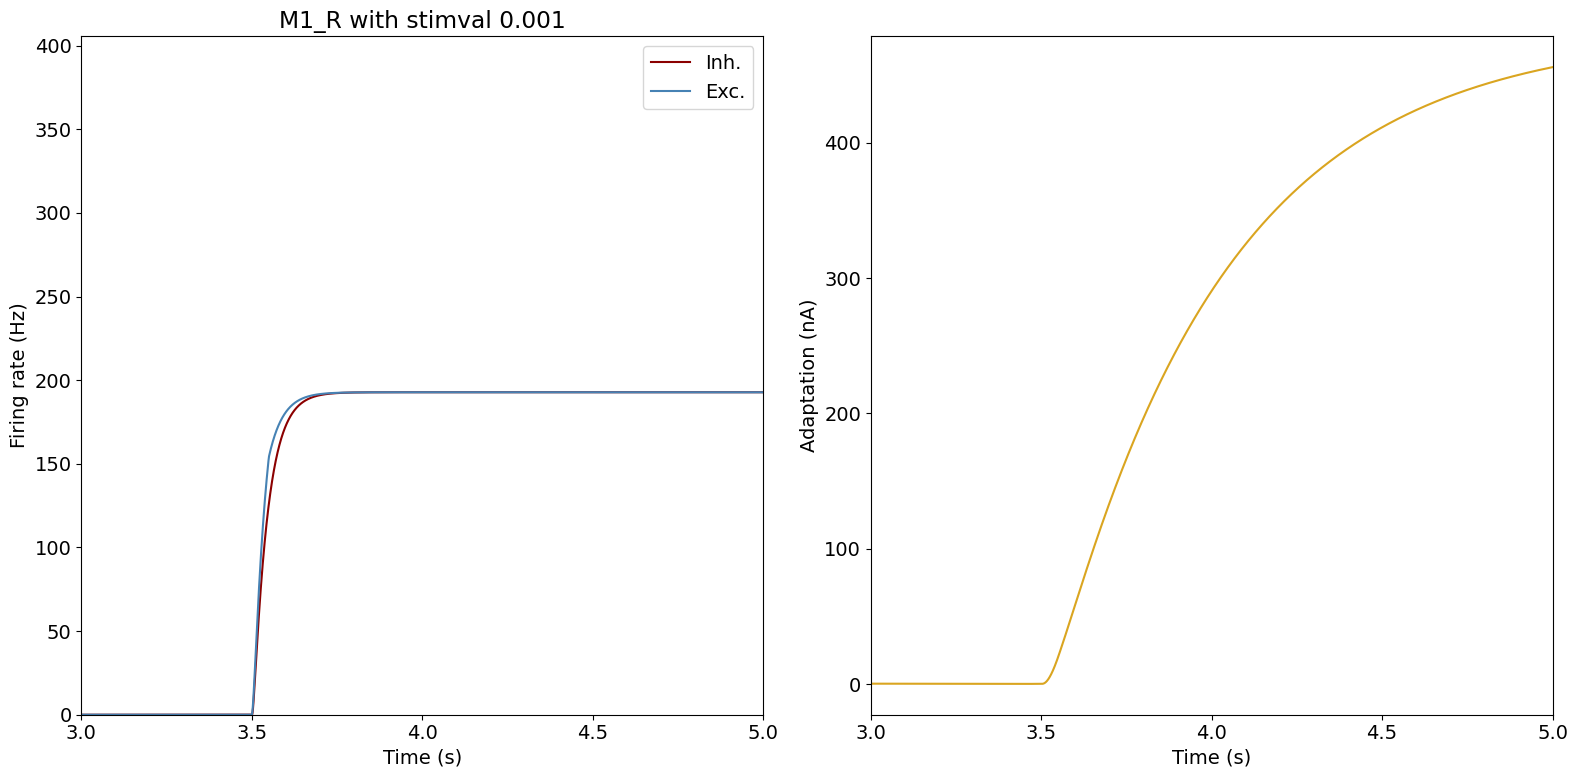

Signals with stimval = 0.41 and 0.405 have been randomly selected
MSE: 91.21913761853249
None
Stim for 50 ms, 0.02 nS, b_val = 5, interstim [1000000000.0] mS in the M1_R
simulation time :1000.0


/home/turan/Downloads/TVB_Linux_2.7.2/TVB_Distribution/tvb_data/lib/python3.10/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


simulation time :2000.0
simulation time :3000.0
simulation time :4000.0
simulation time :5000.0
Simulation took 75.80 seconds to complete.
... loading file: b5_stim0.02_M1_R


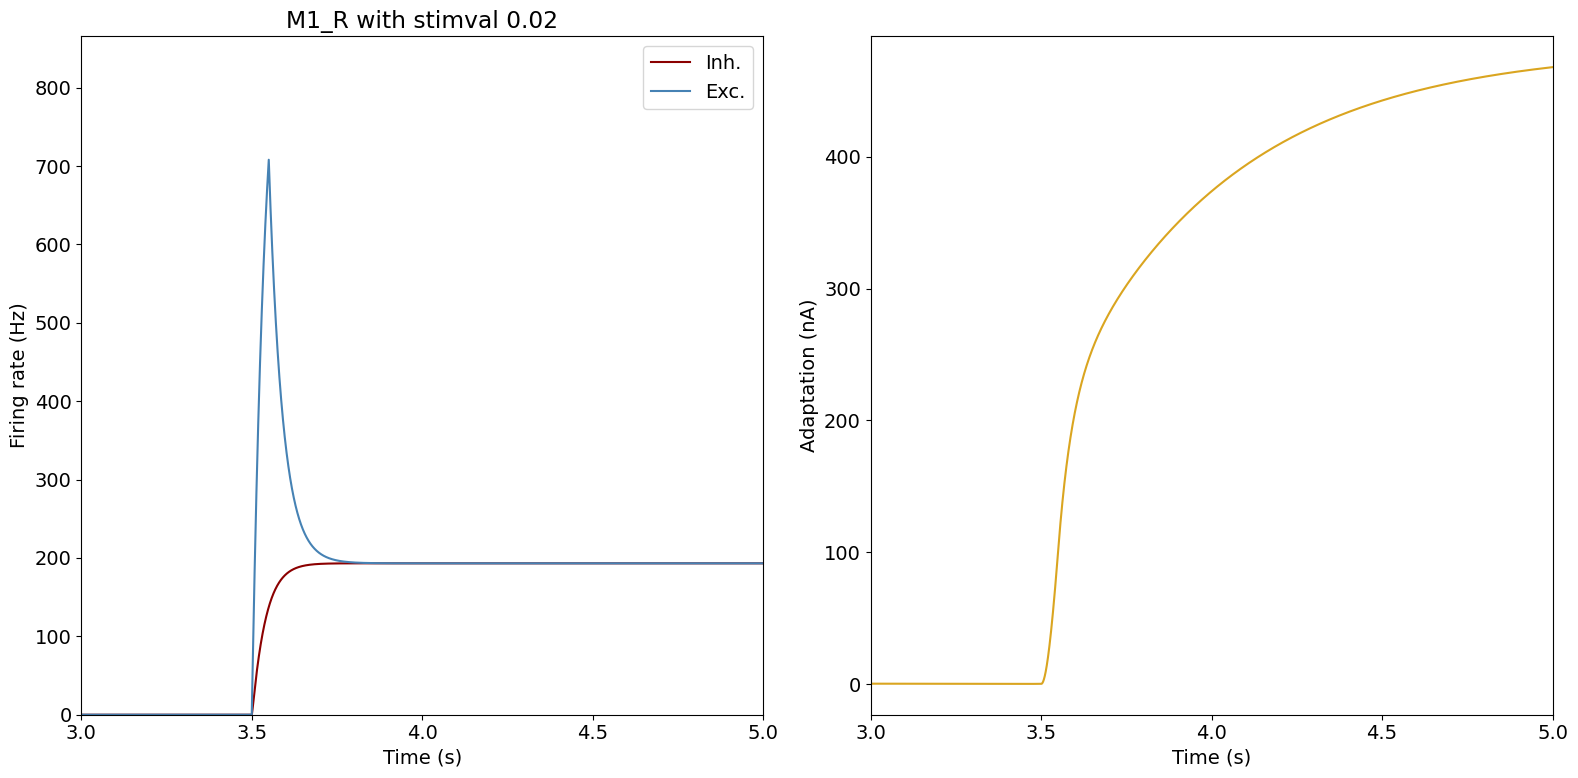

Signals with stimval = 0.001 and 0.41 have been randomly selected
MSE: 122.8891120466958
None
Stim for 50 ms, 0.02 nS, b_val = 5, interstim [1000000000.0] mS in the M1_R
simulation time :1000.0


/home/turan/Downloads/TVB_Linux_2.7.2/TVB_Distribution/tvb_data/lib/python3.10/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


simulation time :2000.0
simulation time :3000.0
simulation time :4000.0
simulation time :5000.0
Simulation took 75.78 seconds to complete.
... loading file: b5_stim0.02_M1_R


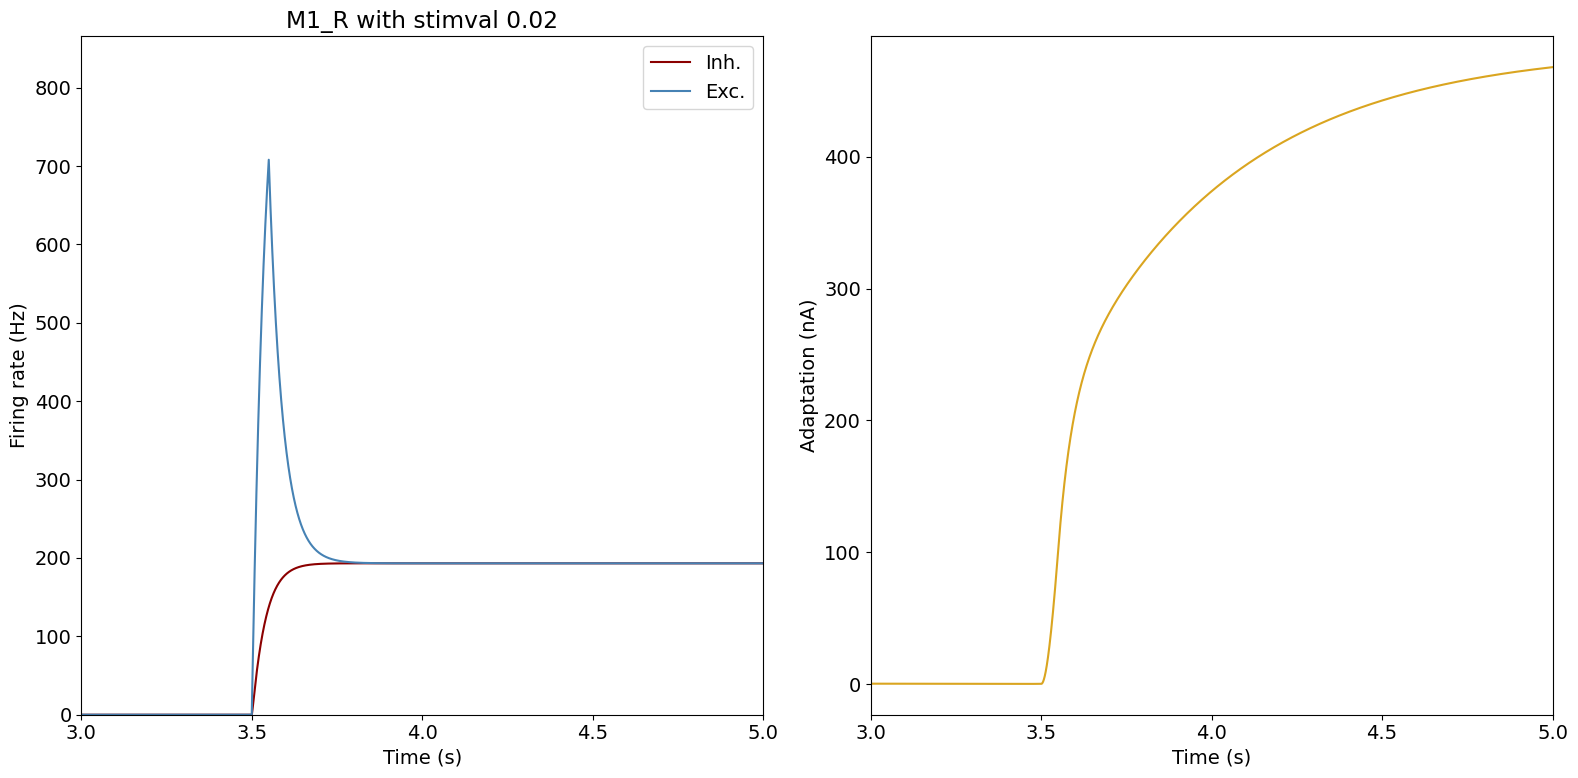

Signals with stimval = 2 and 0.405 have been randomly selected
MSE: 91.42462220067345
None
Stim for 50 ms, 0.02 nS, b_val = 5, interstim [1000000000.0] mS in the M1_R
simulation time :1000.0


/home/turan/Downloads/TVB_Linux_2.7.2/TVB_Distribution/tvb_data/lib/python3.10/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


simulation time :2000.0
simulation time :3000.0
simulation time :4000.0
simulation time :5000.0
Simulation took 75.63 seconds to complete.
... loading file: b5_stim0.02_M1_R


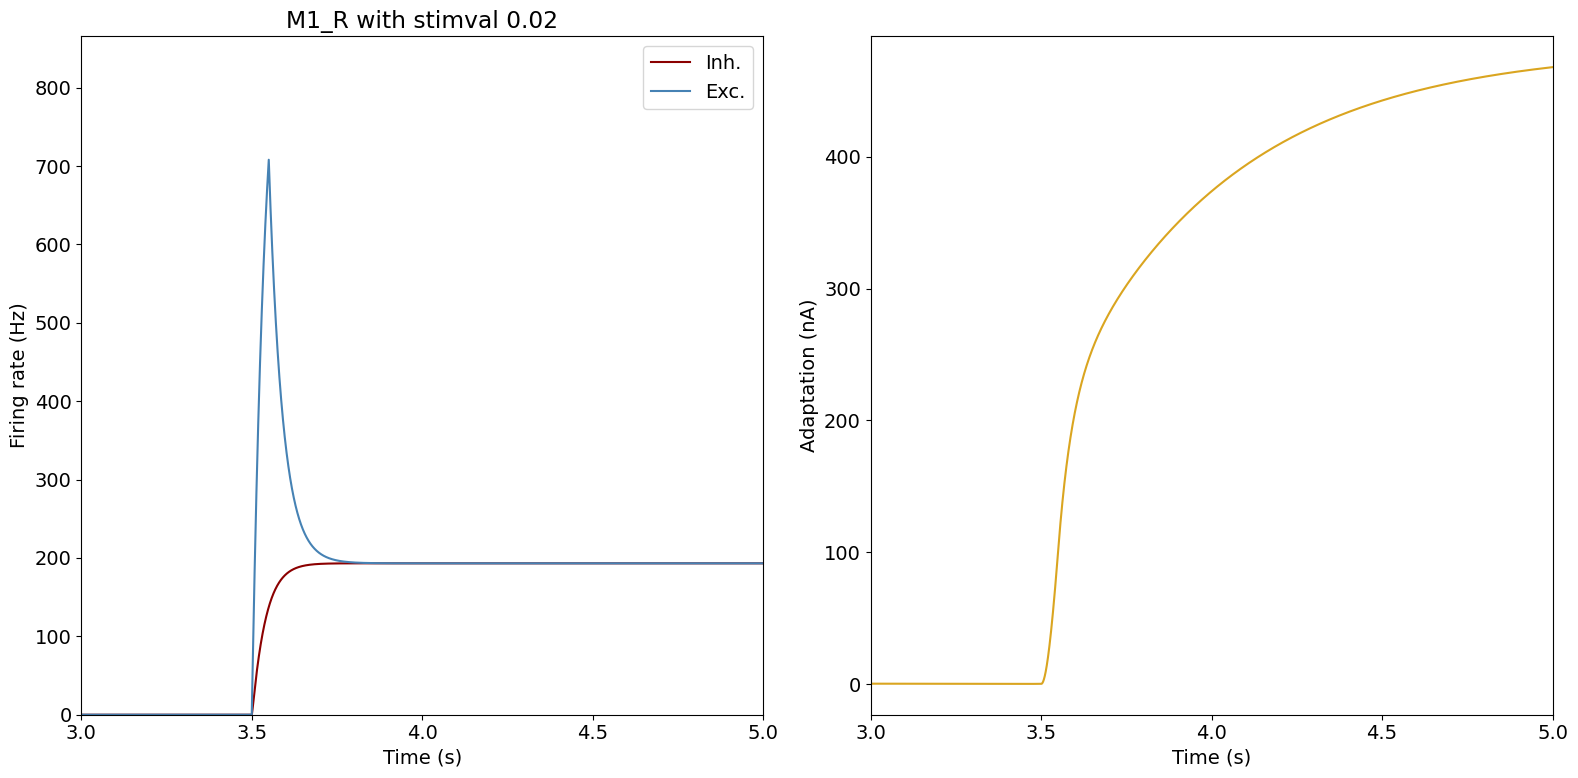

In [17]:
# Define where to 
motor_stim_region = {'M1_R': 'Primary motor area'} 
threshold = 60 # MSE threshold

decision_task_set_nb = 4
for i in range(decision_task_set_nb):
    take_decision(signals_dict, motor_stim_region, threshold, is_plot = True)